# Trained Model Performance Analysis
## Overview
BLAH BLAH BLAH

## Data
BLAH BLAH BLAH

### Training Output Files
BLAH BLAH BLAH
- Results
- Network Configuration
- Optmized Parameters

In [1]:
# Enter the S3 Bucket Name and Region used during deployment
#S3_bucket = <<Bucket Name>>
#rgn = <<AWS Region>>
S3_Bucket = 'itsacat-demo-000'
rgn = 'us-west-2'

In [2]:
# Import Libraries and training results data
from Utils import *
# Training results
results_content = s3_resource.Object(S3_Bucket, 'training_results/results.json')
results_file = results_content.get()['Body'].read().decode('utf-8')
results = loads(results_file)
# Network parameters
parameters_content = s3_resource.Object(S3_Bucket, 'training_input/parameters.json')
parameters_file = parameters_content.get()['Body'].read().decode('utf-8')
NN_parameters = loads(parameters_file)
# Optmized parameters
input_bucket = s3_resource.Bucket(S3_Bucket)
input_bucket.download_file('predict_input/params.h5', '/tmp/params.h5')
with h5py.File('/tmp/params.h5', 'r') as h5file:
    trained_parameters = {}
    for key, item in h5file['/'].items():
        trained_parameters[key] = item.value

### Test Data
BLAH BLAH BLAH Load Data

In [3]:
# Load test dataset
test_set_x_orig, Y, classes = load_data()
num_px = test_set_x_orig.shape[1]

BLAH BLAH BLAH Pre-process Data

In [4]:
# Reshape testing data to a matrix of volum vectors
test_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

# Standardize the data to have features between 0 and 1
X = test_x_flatten / 255

## Results Analysis
### Overview
BLAH BLAH BLAH

Total Processing time: 49 Hours
Final Cost: 0.0032063105530472573


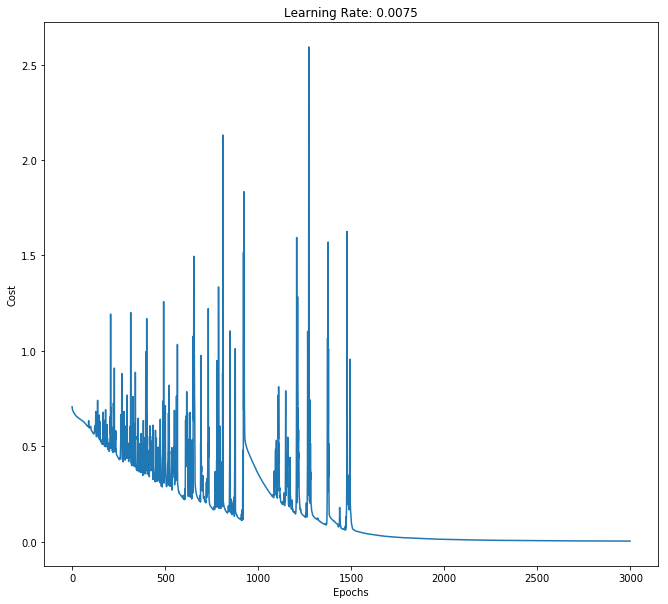

In [5]:
# Training Results Overview
%matplotlib inline
plt.rcParams['figure.figsize'] = (11.0, 10.0)
costs = []
for k, v in results.items():
    # Get the cost at each epoch
    if 'epoch' in k:
        costs.append(v.get('cost'))
    # Get the training start time
    elif 'Start' in k:
        start = datetime.datetime.strptime(v, "%Y-%m-%d %H:%M:%S.%f")
    # Get the training end time
    else:
        end = datetime.datetime.strptime(v, "%Y-%m-%d %H:%M:%S.%f")
delta = end - start
print("Total Processing time: {} Hours".format(int(delta.total_seconds() / 60 /60)))
print("Final Cost: {}".format(results.get('epoch' + str(NN_parameters['epochs']-1))['cost']))
# Plot the results
plt.plot(costs)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.title("Learning Rate: " + str(NN_parameters['learning_rate']))
plt.show;

### Accuracy Score
BLAH BLAH BLAH

In [6]:
# Accuracy Score
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
Y = list(Y.flat)
y = predict(X, NN_parameters, trained_parameters)
Y_pred = list(y.flat)
print("Accuracy Scoore: {}".format(accuracy_score(Y, Y_pred)))

Accuracy Scoore: 0.78


### Confusion Matrix
A **[Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)** is a table that describes the overall performance of a "supervised" classification model on a set of test data. 

In [7]:
# Create confusion matrix
cm = confusion_matrix(Y, Y_pred)
print(cm)

[[12  5]
 [ 6 27]]


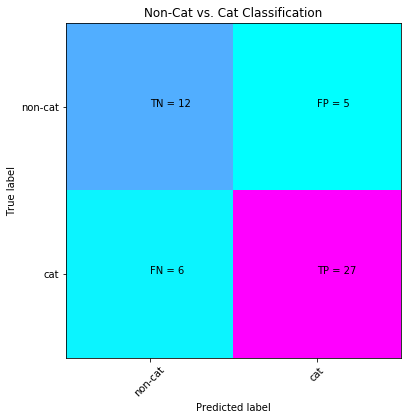

In [8]:
# Plot confusion Matrix
%matplotlib inline
plt.rcParams['figure.figsize'] = (6.0, 7.0)
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.cool)
classNames = [classes[0].decode('utf-8'), classes[1].decode('utf-8')]
plt.title('Non-Cat vs. Cat Classification')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#### Confusion Matrix Interpretation:
**True Positives (TP):** Images that were correctly classified as a "cat" picture, i.e. truly predicted as positive.

In [9]:
# True Positive
TP = cm[1, 1]
print("TP = "+str(TP))

TP = 27


**True Negatives (TN):** Images that were correclty classified as **NOT** a "cat" picture, i.e. truly predicted as negative.

In [10]:
# True Negative
TN = cm[0, 0]
print("TN = "+str(TN))

TN = 12


**False Positives (FP):** Images *incorrectly* classified as a "cat" picture, i.e. falsely predicted as positive.

In [11]:
# False Positive
FP = cm[0, 1]
print("FP = "+str(FP))

FP = 5


**False Negatives (FN):** Images *incorectly* classified as **NOT** a "cat" picture, i.e. falsely predicted as negative.

In [12]:
# False Negative
FN = cm[1, 0]
print("FN = "+str(FN))

FN = 6


### Insight Derived from the Confusion Matrix
The **Confusion Matrix** quadrants can be used to provide additional insight into the classificaiton model's overall performance.

**Classification Accuracy:** Overall, how often did the classifier correctly predict images as a "cat" picture?
>**Note:** The Classification Accuracy calculation should correlate directly to the **Accuracy Score**.

$$ACC = \frac{TP + TN}{TP + TN + FP + FN}$$

In [13]:
# Classification Accuracy
print("Classification Accuracy: {}".format(float((TP + TN) / (TP + TN + FP + FN))))

Classification Accuracy: 0.78


**Classification Error:** Overall, how often did the classifier incorrectly predict predict images as a "cat" picture?

$$Error = \frac{FP + FN}{TP + TN + FP + FN}$$

In [14]:
print("Classification Error: {}".format(float((FP + FN) / (TP + TN + FP + FN))))

Classification Error: 0.22


**Sensitivity:** When the image is a "cat" picture, how often does the model classify the image correctly, i.e. how "sensitive" is the model to detecting the "cat" picture?
>**Note:** Sesnisitvity is often referred to as the "True Positive Rate (TPR)" or "Recall".

$$TPR = \frac{TP}{TP + FN}$$

In [15]:
print("Sensitivity: {}".format(float((TP) / (TP + FN))))

Sensitivity: 0.8181818181818182


**Specificity:** When the image is **NOT** a "cat" picture, how often does the model classify the image correctly, i.e. how "specific" or "selective" is the model to detecting that there is no cat in the "cat" picture?
>**Note:** Specificity is often referred to as the "True Negative Rate (TNR)".

$$TNR = \frac{TN}{TN + FP}$$

In [16]:
print("Specificity: {}".format(float((TN) / (TN + FP))))

Specificity: 0.7058823529411765


**False Positive Rate (FPR):** When the image is **NOT** a "cat" picture, how often does the model classify the image incorrectly?

$$FPR = \frac{FP}{FP + TN}$$

In [17]:
print("False Positive Rate: {}".format(float((FP) / (FP + TN))))

False Positive Rate: 0.29411764705882354


**Precision:** When the image is correclty classified as a "cat" picture, how often is that classificaiton correct?
>**Note:** Precision is often referred to as the "Positive Predictive Value (PPV)".

$$PPV = \frac{TP}{TP + FP}$$

In [18]:
print("Precision: {}".format(float((TP) / (TP + FP))))

Precision: 0.84375


From this additional insight it can be derived that BLAH BLAH BLAH

- Want *Sensitivity* to be high.
- Want *Specificty* to be high.
- Our model generally specific as weell as sensitive = generalizes well
- Low FRP and high Precision = pretty good model = generalizes well

### Mislabeled Images
More insight by viewing actualy images that incorrectly classified (Classification Error):

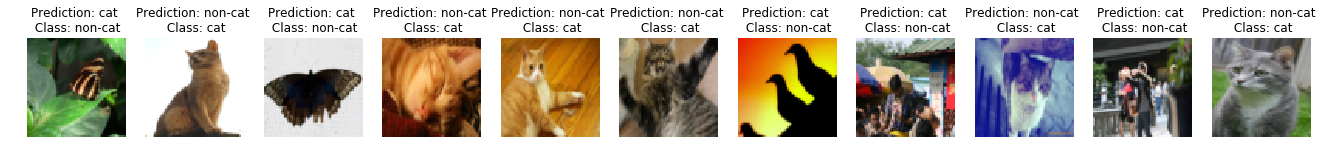

In [19]:
print_mislabeled_images(NN_parameters, trained_parameters)

**A few type of images the model tends to do poorly on include:**
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness and Contrast of the picture
- Scale variation (cat is very large or small in image)

## Testing with an Unseen Image: Grumpy Cat
True testiment BLAH BLAH BLAH  when actually testing against a previously unseen image...blah blah blah

y = 1
The trained model predicts a "cat" picture.


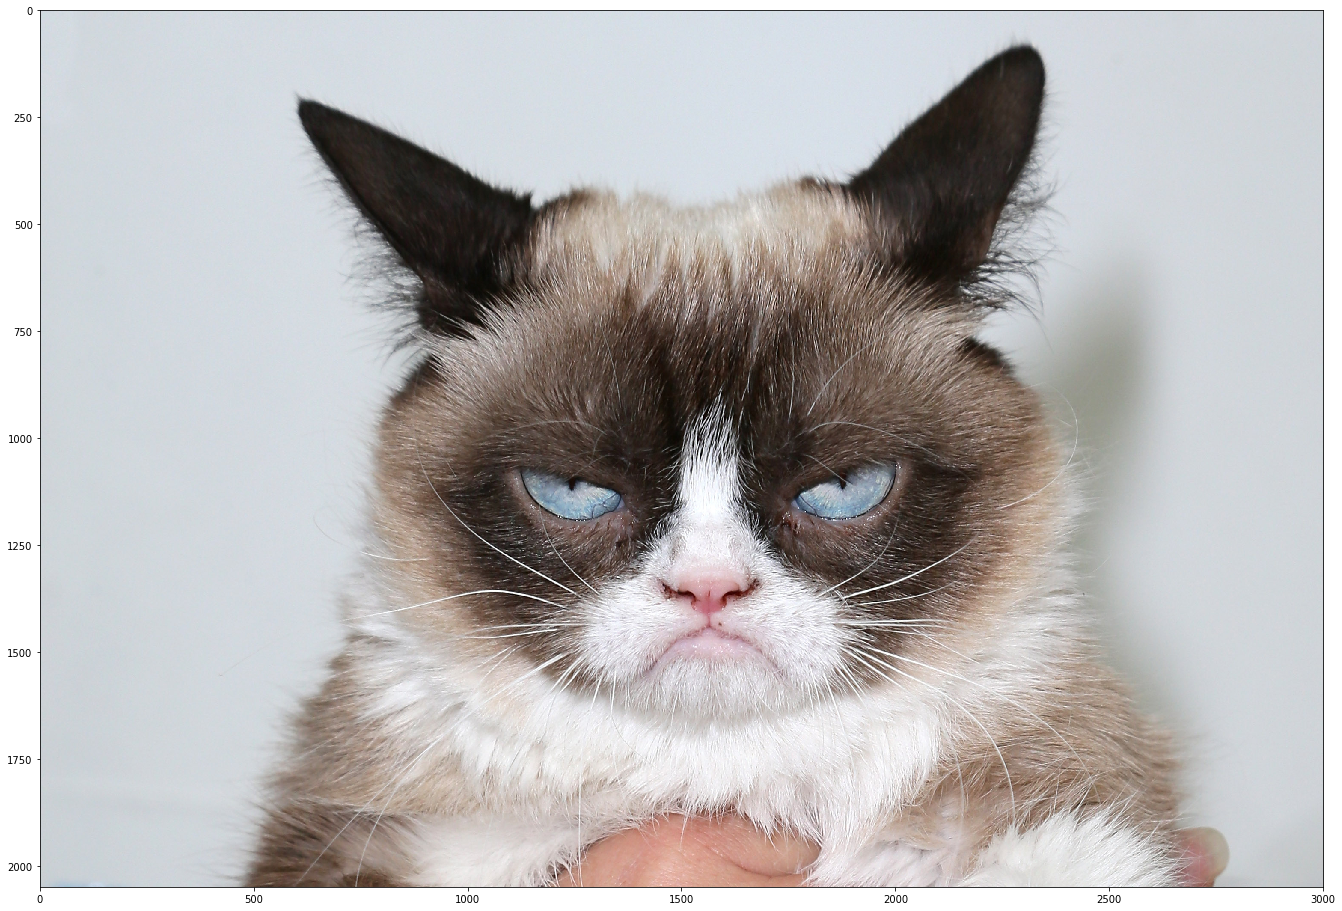

In [20]:
# Display and predict against grumpy cat image
from skimage import transform
my_image = "grumpy_cat.jpeg"
y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
fname = "images/" + my_image
img = plt.imread(fname)
image = transform.resize(img, (num_px, num_px), mode='constant').reshape((num_px * num_px * 3, 1))
my_predicted_image = predict(image, NN_parameters, trained_parameters)
plt.imshow(img);
print ("y = " + str(np.squeeze(my_predicted_image)) + \
       "\nThe trained model predicts a \"" + \
       classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")